# Notebook to Evaluate New Bathymetry as the run comes in

## Salinity top 5 m

In [560]:
import cmocean.cm as cm
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
import xarray as xr

In [291]:
foramt = "{:.2}"
myformat = {'bias': foramt, 'rmse': foramt, 'swillmott': foramt, 'slopedev': foramt, 'const': foramt,
                         'systematic': foramt, 'nonsystematic':foramt, 
                    'spread': foramt}

In [292]:
def bias(df, obs, mod):
    diffy = df[mod] - df[obs]
    return diffy.count(), diffy.mean()

In [293]:
def rmse(df, obs, mod):
    return (np.sqrt(((df[mod] - df[obs])**2).mean()))

In [294]:
def swillmott(df, obs, mod):
    meanobs = df[obs].mean()
    return (((df[mod] - df[obs])**2).sum()
            /(( (df[mod] - meanobs).abs() + (df[obs] - meanobs).abs() )**2).sum())

In [295]:
def slope_inter(df, obs, mod):
    X = df[obs]
    y = df[mod]
    X2 = X**2
    X2 = X**2
    X3 = X**3
    X4 = X**4
    X5 = X**5
    X6 = X**6
#    X = np.column_stack((X, X2, X3, X4, X5, X6))
    X = sm.add_constant(X)

    # Fit and make the predictions by the model
    model = sm.OLS(y, X, missing='drop').fit()
    predictions = model.predict(X)
    
    nonsyst = np.sqrt(((y - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obs])**2).mean())
#    print (model.params)
    return predictions, model.params['SA'], model.params['SA'], model.params['const'], systematic, nonsyst

In [296]:
def spread(df, obs, mod):
    return 1 - ((df[mod] - df[mod].mean())**2).mean() / ((df[obs] - df[obs].mean())**2).mean() 

In [297]:
def read_pieces(pieces):
    temp1 = pd.read_csv(pieces[0])
    if 'ferry' in pieces[0]:
        temp1['k'] = 1.5
    for piece in pieces[1:]:
        nextpiece = pd.read_csv(piece)
        if 'ferry' in piece:
            nextpiece['k'] = 1.5
        temp1 = pd.concat([temp1, nextpiece], ignore_index=True)
    return temp1

In [298]:
def triple_plots(dowhich, temp1, temp2, temp3):
    No = "No"
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    if dowhich[0] != No:
        answer1 = plot_and_stats(fig, axs[0], temp1, dowhich[0])
    else:
        answer1 = No
    if dowhich[1] != No:
        answer2 = plot_and_stats(fig, axs[1], temp2, dowhich[1])
    else:
        answer2 = No
    if dowhich[2] != No:
        answer3 = plot_and_stats(fig, axs[2], temp3, dowhich[2])
    else:
        answer3 = No
    return answer1, answer2, answer3

In [367]:
def plot_and_stats(fig, ax, temp1, name, withpred=True, witharrows=True):
    vmax = 34
    vmin = 0
    condition = temp1.k < 5
    title = 'Salinity top 5 m'
    counts, xedges, yedges, color = ax.hist2d(temp1.SA[condition], temp1.mod_vosaline[condition], 
                                           bins=np.arange(vmin, vmax, 0.5), norm=LogNorm());
    fig.colorbar(color, ax=ax)
    number, tbias = bias(temp1[condition], 'SA', 'mod_vosaline')
    trmse = rmse(temp1[condition], 'SA', 'mod_vosaline')
    tswillmott = swillmott(temp1[condition], 'SA', 'mod_vosaline')
    predictions, m2, m, c, syst, nonsyst = slope_inter(temp1[condition], 'SA', 'mod_vosaline')
    tspread = spread(temp1[condition], 'SA', 'mod_vosaline')
    ax.plot([vmin, vmax], [vmin, vmax], 'w-');
    xr = np.arange(vmin, vmax, 0.5)
    if withpred:
        ax.plot(temp1.SA[condition], predictions, 'r.')
    if witharrows:
        ax.arrow(3, 27, 0, 1-tbias/2, head_width=0.5, head_length=0.2, length_includes_head=True)
        ax.arrow(3, 29, 0, -1+tbias/2, head_width=0.5, head_length=0.2, length_includes_head=True)
        ax.arrow(4, 27, 0, 1-syst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
        ax.arrow(4, 29, 0, -1+syst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
        ax.arrow(5, 27, 0, 1-nonsyst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
        ax.arrow(5, 29, 0, -1+nonsyst/2, head_width=0.5, head_length=0.2, length_includes_head=True);
    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
          'swillmott': tswillmott,
          'slopedev': 1-m,
          'const': c,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}
    if witharrows:
        ax.text(3-0.2, 22, 'bias', rotation=90)
        ax.text(4-0.2, 21, 'systematic', rotation=90)
        ax.text(5-0.2, 20, 'non-systematic', rotation=90)
        ax.set_title(f'{name}, {title}');
    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2, counts


In [300]:
pieces1 = ('/home/sallen/202007/H201812/ObsModel_H201812_ctd_20150101_20151231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_ctd_20160101_20161231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_ctd_20170101_20171231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_psfts_20150101_20151231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_psfts_20160101_20161231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_psfts_20170101_20171231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_pugts_20150101_20151231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_pugts_20160101_20161231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_pugts_20170101_20171231.csv',
          )
pieces2 = (
          '/home/sallen/202007/H201812/ObsModel_H201812_ferry_20150101_20151231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_ferry_20160101_20161231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_ferry_20170101_20171231.csv'
         )

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812o,39364,-0.75,2.3,0.1,0.058,0.8,0.84,2.1,-0.35
H201812f,414515,1.9,5.2,0.22,0.51,1.2e+01,3.8,3.5,0.46


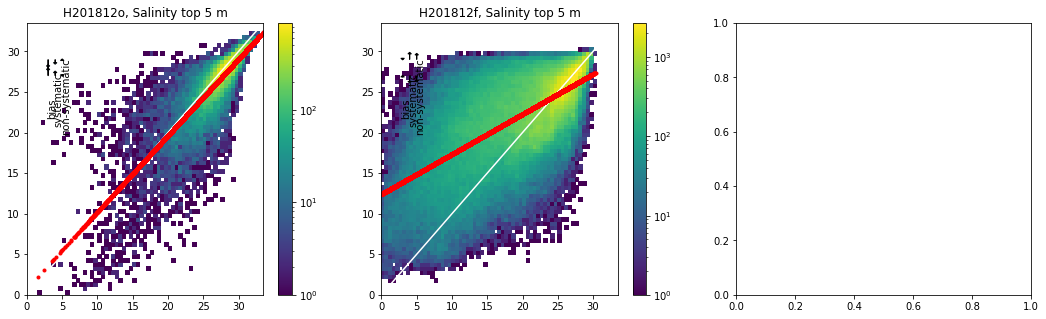

In [301]:
temp1 = read_pieces(pieces1)
#temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)

temp2 = read_pieces(pieces2)
temp2['SA'] = temp2['salinity (g/kg)']
temp2.drop(columns='Unnamed: 0', inplace=True)
temp2.drop_duplicates(inplace=True)

dowhich = ['H201812o', 'H201812f', 'No'] 

d201812o, d201812f, stuff = triple_plots(dowhich, temp1, cleanup_ferry(temp2), temp1)
alltogether = pd.concat([d201812o, d201812f], axis=0)
alltogether.style.format(myformat).apply(highlight_max_min)

In [306]:
pieces1 = ('/home/sallen/202007/H201905/ObsModel_H201905_ctd_20150101_20151231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_ctd_20160101_20161231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_ctd_20170101_20171231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_psfts_20150101_20151231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_psfts_20160101_20161231.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_psfts_20170101_20171231.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_pugts_20150101_20151231.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_pugts_20160101_20161231.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_pugts_20170101_20171231.csv',
          )
pieces2 = (
          '/home/sallen/202007/H201905/ObsModel_H201905_ferry_20150101_20151231.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_ferry_20160101_20161231.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_ferry_20170101_20171231.csv'
         )

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812o,39364,-0.75,2.3,0.1,0.058,0.8,0.84,2.1,-0.35
H201812f,414515,1.9,5.2,0.22,0.51,1.2e+01,3.8,3.5,0.46
H201905o,39364,-0.77,2.3,0.1,0.058,0.78,0.86,2.1,-0.35
H201905f,414513,1.8,5.1,0.21,0.5,1.2e+01,3.7,3.6,0.44


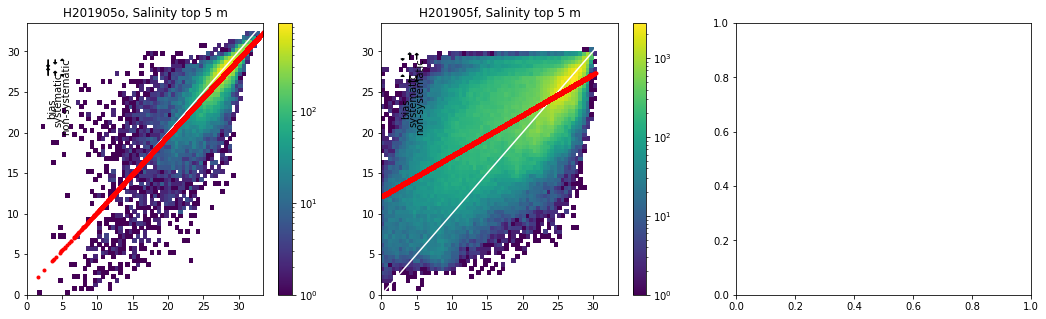

In [307]:
temp1 = read_pieces(pieces1)
#temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)

temp2 = read_pieces(pieces2)
temp2['SA'] = temp2['salinity (g/kg)']
temp2.drop(columns='Unnamed: 0', inplace=True)
temp2.drop_duplicates(inplace=True)

dowhich = ['H201905o', 'H201905f', 'No'] 

d201905o, d201905f, stuff = triple_plots(dowhich, temp1, cleanup_ferry(temp2), temp1)
alltogether = pd.concat([d201812o, d201812f, d201905o, d201905f], axis=0)
alltogether.style.format(myformat).apply(highlight_max_min)

In [308]:
pieces1 = ('/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ctd_20150101_20151231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TSPUG_20150101-20151231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ctd_20160101_20161231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TSPUG_20160101-20161231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20170101-20170331.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20170401-20170630.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20170701-20170930.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20171001-20171231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TSPUG_20170101-20171231.csv',   
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_psfts_20150101_20151231.csv',
          '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_psfts_20160101_20161231.csv',
          '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_psfts_20170101_20171231.csv'
         )
pieces2 = (
      '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20150101_20150331.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20150401_20150630.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20150701_20150930.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20151001_20151231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20160101_20160331.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20160301_20160630.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20160601_20160930.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20161001_20161231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20170101_20170331.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20170401_20170630.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20170701_20170930.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20171001_20171231.csv',
)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812o,39364,-0.75,2.3,0.1,0.058,0.8,0.84,2.1,-0.35
H201812f,414515,1.9,5.2,0.22,0.51,1.2e+01,3.8,3.5,0.46
H201905o,39364,-0.77,2.3,0.1,0.058,0.78,0.86,2.1,-0.35
H201905f,414513,1.8,5.1,0.21,0.5,1.2e+01,3.7,3.6,0.44
Cp2o,39325,-0.77,2.3,0.1,0.052,0.64,0.84,2.1,-0.38
Cp2f,417883,1.9,5.2,0.22,0.51,1.2e+01,3.8,3.6,0.46


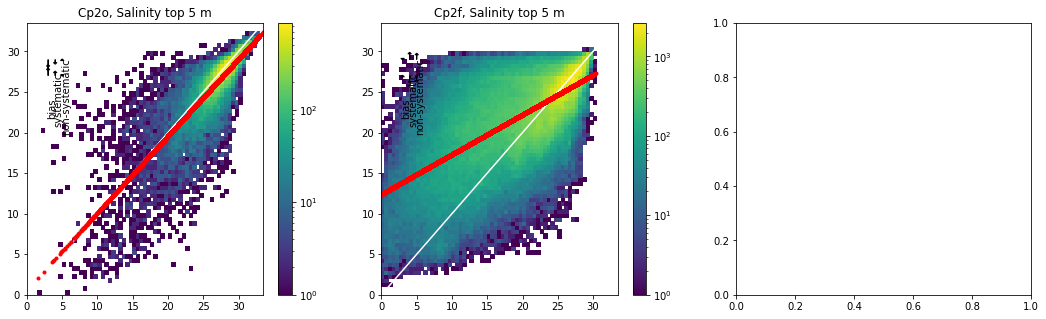

In [309]:
temp1 = read_pieces(pieces1)
#temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)

temp2 = read_pieces(pieces2)
temp2['SA'] = temp2['salinity (g/kg)']
temp2.drop(columns='Unnamed: 0', inplace=True)
temp2.drop_duplicates(inplace=True)

dowhich = ['Cp2o', 'Cp2f', 'No'] 

Cp2o, Cp2f, stuff = triple_plots(dowhich, temp1, cleanup_ferry(temp2), temp1)
alltogether = pd.concat([d201812o, d201812f, d201905o, d201905f, Cp2o, Cp2f], axis=0)
alltogether.style.format(myformat).apply(highlight_max_min)

In [310]:
pieces1 = ('/home/sallen/202007/202007D-again/ObsModel_202007D-again_TS_20150101-20150331.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_TS_20150401-20150630.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_TS_20150701-20150930.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_TS_20151001-20151231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_psfts_20150101_20151231.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_pugts_20150101_20151231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_ctd_20160101_20161231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_psfts_20160101_20161231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_pugts_20160101_20161231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_ctd_20170101_20171231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_psfts_20170101_20171231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_pugts_20170101_20171231.csv',
         )
pieces2 = (
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_ferry_20150101_20151231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_ferry_20160101_20161231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_ferry_20170101_20171231.csv'
        )

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812o,39364,-0.75,2.3,0.1,0.058,0.8,0.84,2.1,-0.35
H201812f,414515,1.9,5.2,0.22,0.51,1.2e+01,3.8,3.5,0.46
H201905o,39364,-0.77,2.3,0.1,0.058,0.78,0.86,2.1,-0.35
H201905f,414513,1.8,5.1,0.21,0.5,1.2e+01,3.7,3.6,0.44
Cp2o,39325,-0.77,2.3,0.1,0.052,0.64,0.84,2.1,-0.38
Cp2f,417883,1.9,5.2,0.22,0.51,1.2e+01,3.8,3.6,0.46
Dagaino,39304,-0.77,2.3,0.1,0.057,0.77,0.85,2.1,-0.35
Dagainf,414515,1.8,5.2,0.22,0.51,1.2e+01,3.7,3.6,0.45


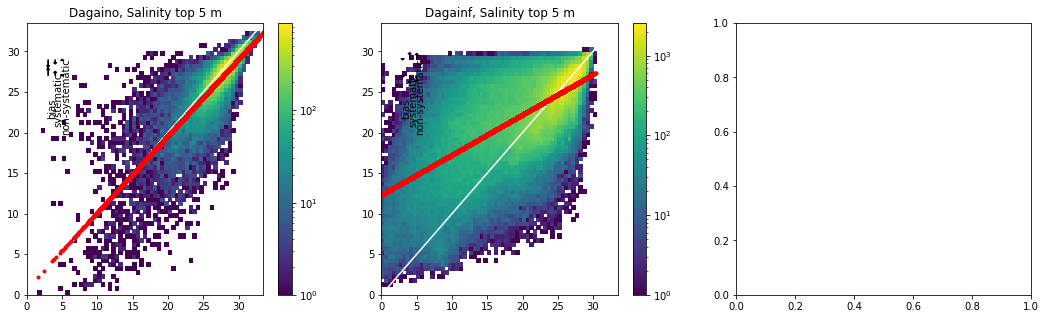

In [311]:
temp1 = read_pieces(pieces1)
#temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)

temp2 = read_pieces(pieces2)
temp2['SA'] = temp2['salinity (g/kg)']
temp2.drop(columns='Unnamed: 0', inplace=True)
temp2.drop_duplicates(inplace=True)

dowhich = ['Dagaino', 'Dagainf', 'No'] 

Dagaino, Dagainf, stuff = triple_plots(dowhich, temp1, cleanup_ferry(temp2), temp1)
alltogether = pd.concat([d201812o, d201812f, d201905o, d201905f, Cp2o, Cp2f, Dagaino, Dagainf], axis=0)
alltogether.style.format(myformat).apply(highlight_max_min)

In [312]:
pieces1 = ('/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_ctd_20150101_20151231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_ctd_20160101_20161231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_ctd_20170101_20171231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_psfts_20150101_20151231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_psfts_20160101_20161231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_psfts_20170101_20171231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_pugts_20150101_20151231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_pugts_20160101_20161231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_pugts_20170101_20171231.csv', 
         )
pieces2 = (
         '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_ferry_20150101_20151231.csv',     
         '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_ferry_20160101_20161231.csv',
         '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_ferry_20170101_20171231.csv'
         )

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812o,39364,-0.75,2.3,0.1,0.058,0.8,0.84,2.1,-0.35
H201812f,414515,1.9,5.2,0.22,0.51,1.2e+01,3.8,3.5,0.46
H201905o,39364,-0.77,2.3,0.1,0.058,0.78,0.86,2.1,-0.35
H201905f,414513,1.8,5.1,0.21,0.5,1.2e+01,3.7,3.6,0.44
Cp2o,39325,-0.77,2.3,0.1,0.052,0.64,0.84,2.1,-0.38
Cp2f,417883,1.9,5.2,0.22,0.51,1.2e+01,3.8,3.6,0.46
Dagaino,39304,-0.77,2.3,0.1,0.057,0.77,0.85,2.1,-0.35
Dagainf,414515,1.8,5.2,0.22,0.51,1.2e+01,3.7,3.6,0.45
DnoCilo,39364,-0.79,2.3,0.1,0.047,0.46,0.86,2.1,-0.37
DnoCilf,414513,1.9,5.2,0.23,0.52,1.3e+01,3.9,3.5,0.47


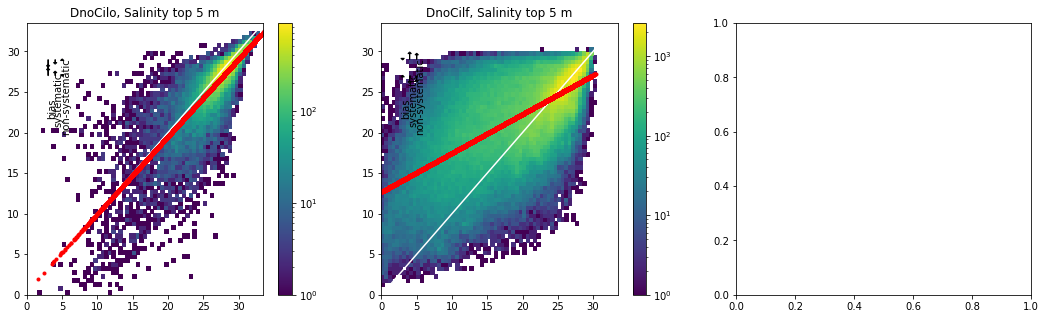

In [313]:
temp1 = read_pieces(pieces1)
#temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)

temp2 = read_pieces(pieces2)
temp2['SA'] = temp2['salinity (g/kg)']
temp2.drop(columns='Unnamed: 0', inplace=True)
temp2.drop_duplicates(inplace=True)

dowhich = ['DnoCilo', 'DnoCilf', 'No'] 

DnoCilo, DnoCilf, stuff = triple_plots(dowhich, temp1, cleanup_ferry(temp2), temp1)
alltogether = pd.concat([d201812o, d201812f, d201905o, d201905f, Cp2o, Cp2f, Dagaino, Dagainf,
                        DnoCilo, DnoCilf], axis=0)
alltogether.style.format(myformat).apply(highlight_max_min)

In [314]:
pieces1 = ('/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_ctd_20150101_20151231.csv',
          '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_psfts_20150101_20151231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_pugts_20150101_20151231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_ctd_20160101_20161231.csv',
          '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_psfts_20160101_20161231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_pugts_20160101_20161231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_ctd_20170101_20171231.csv',
          '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_psfts_20170101_20171231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_pugts_20170101_20171231.csv',
         )
pieces2 = (
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_ferry_20150101_20151231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_ferry_20160101_20161231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_ferry_20170101_20171231.csv'
         )

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812o,39364,-0.75,2.3,0.1,0.058,0.8,0.84,2.1,-0.35
H201905o,39364,-0.77,2.3,0.1,0.058,0.78,0.86,2.1,-0.35
Cp2o,39325,-0.77,2.3,0.1,0.052,0.64,0.84,2.1,-0.38
Dagaino,39304,-0.77,2.3,0.1,0.057,0.77,0.85,2.1,-0.35
DnoCilo,39364,-0.79,2.3,0.1,0.047,0.46,0.86,2.1,-0.37
DLowRo,39364,-0.79,2.3,0.1,0.046,0.44,0.86,2.2,-0.38


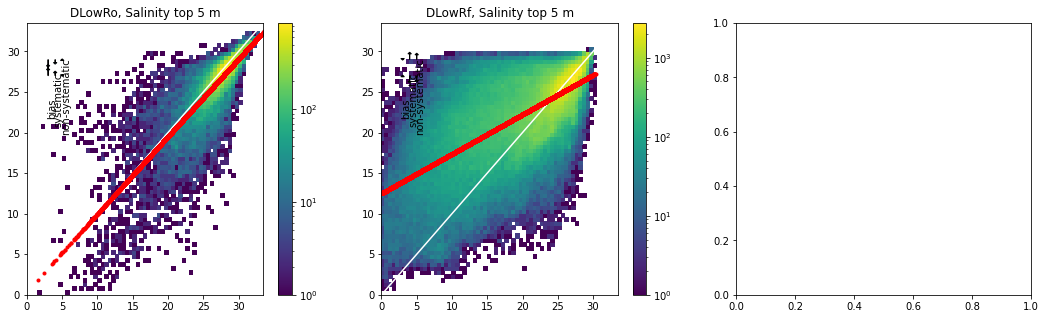

In [315]:
temp1 = read_pieces(pieces1)
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)

temp2 = read_pieces(pieces2)
temp2['SA'] = temp2['salinity (g/kg)']
temp2.drop(columns='Unnamed: 0', inplace=True)
temp2.drop_duplicates(inplace=True)

dowhich = ['DLowRo', 'DLowRf', 'No'] 

DLowRo, DLowRf, stuff = triple_plots(dowhich, temp1, cleanup_ferry(temp2), temp1)

alltogethero = pd.concat([d201812o, d201905o,  Cp2o,  Dagaino, 
                        DnoCilo,  DLowRo,], axis=0)
alltogetherf = pd.concat([d201812f,  d201905f,  Cp2f,  Dagainf,
                         DnoCilf,  DLowRf], axis=0)
alltogethero.style.format(myformat).apply(highlight_max_min)


In [316]:
alltogetherf.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812f,414515,1.9,5.2,0.22,0.51,1.2e+01,3.8,3.5,0.46
H201905f,414513,1.8,5.1,0.21,0.5,1.2e+01,3.7,3.6,0.44
Cp2f,417883,1.9,5.2,0.22,0.51,1.2e+01,3.8,3.6,0.46
Dagainf,414515,1.8,5.2,0.22,0.51,1.2e+01,3.7,3.6,0.45
DnoCilf,414513,1.9,5.2,0.23,0.52,1.3e+01,3.9,3.5,0.47
DLowRf,414514,1.9,5.2,0.22,0.51,1.2e+01,3.8,3.6,0.46


In [320]:
pieces1 = (
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ctd_20150101_20151231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ctd_20160101_20161231.csv',
          '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ctd_20170101_20171231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_TSPUG_20150101-20151231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_pugts_20160101_20161231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_pugts_20170101_20171231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_psfts_20150101_20151231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_psfts_20160101_20161231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_psfts_20170101_20171231.csv',
)
pieces2 = (
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20150101_20150331.csv',
        '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20150401_20150630.csv',
        '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20150701_20150930.csv',
        '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20151001_20151231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20160101_20160331.csv',
    '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20160401_20160630.csv',
    '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20160701_20160930.csv',
    '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20161001_20161231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20170101_20171231.csv'
)
pieces3 = ('/home/sallen/202007/202007C-p3/ObsModel_202007Cp3f0_ferry_20150101_20151231.csv',
          '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3f0_ferry_20160101_20161231.csv',
          '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3f0_ferry_20170101_20171231.csv'
          )

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812o,39364,-0.75,2.3,0.1,0.058,0.8,0.84,2.1,-0.35
H201905o,39364,-0.77,2.3,0.1,0.058,0.78,0.86,2.1,-0.35
Cp2o,39325,-0.77,2.3,0.1,0.052,0.64,0.84,2.1,-0.38
Dagaino,39304,-0.77,2.3,0.1,0.057,0.77,0.85,2.1,-0.35
DnoCilo,39364,-0.79,2.3,0.1,0.047,0.46,0.86,2.1,-0.37
DLowRo,39364,-0.79,2.3,0.1,0.046,0.44,0.86,2.2,-0.38
Cp3o,39364,-0.57,2.0,0.085,0.05,0.78,0.64,1.9,-0.29


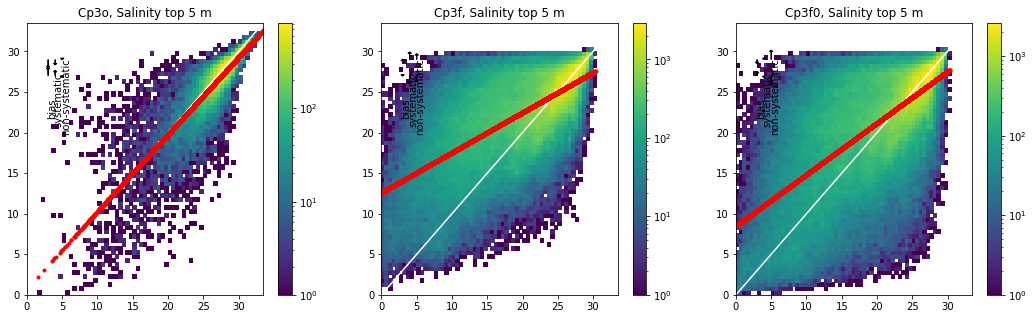

In [321]:
temp1 = read_pieces(pieces1)
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)

temp2 = read_pieces(pieces2)
temp2['SA'] = temp2['salinity (g/kg)']
temp2.drop(columns='Unnamed: 0', inplace=True)
temp2.drop_duplicates(inplace=True)

temp3 = read_pieces(pieces3)
temp3['SA'] = temp3['salinity (g/kg)']
temp3.drop(columns='Unnamed: 0', inplace=True)
temp3.drop_duplicates(inplace=True)

dowhich = ['Cp3o', 'Cp3f', 'Cp3f0'] 

Cp3o, Cp3f, Cp3f0 = triple_plots(dowhich, temp1, cleanup_ferry(temp2), cleanup_ferry(temp3))

alltogethero = pd.concat([d201812o, d201905o,  Cp2o,  Dagaino, 
                        DnoCilo,  DLowRo, Cp3o], axis=0)
alltogetherf = pd.concat([d201812f,  d201905f,  Cp2f,  Dagainf,
                         DnoCilf,  DLowRf, Cp3f, Cp3f0], axis=0)
alltogethero.style.format(myformat).apply(highlight_max_min)

In [322]:
alltogetherf.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812f,414515,1.9,5.2,0.22,0.51,1.2e+01,3.8,3.5,0.46
H201905f,414513,1.8,5.1,0.21,0.5,1.2e+01,3.7,3.6,0.44
Cp2f,417883,1.9,5.2,0.22,0.51,1.2e+01,3.8,3.6,0.46
Dagainf,414515,1.8,5.2,0.22,0.51,1.2e+01,3.7,3.6,0.45
DnoCilf,414513,1.9,5.2,0.23,0.52,1.3e+01,3.9,3.5,0.47
DLowRf,414514,1.9,5.2,0.22,0.51,1.2e+01,3.8,3.6,0.46
Cp3f,412012,2.1,5.2,0.22,0.51,1.3e+01,3.9,3.5,0.47
Cp3f0,414518,0.92,5.0,0.18,0.37,8.5,2.5,4.3,0.14


In [323]:
pieces1 = ('/home/sallen/202007/202007F/ObsModel_202007F_ctd_20150101_20151231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_psfts_20150101_20151231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_pugts_20150101_20151231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_ctd_20160101_20161231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_psfts_20160101_20161231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_pugts_20160101_20161231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_ctd_20170101_20171231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_psfts_20170101_20171231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_pugts_20170101_20171231.csv',
          )
pieces2 = (
         '/home/sallen/202007/202007F/ObsModel_202007F_ferry_20150101_20151231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_ferry_20160101_20161231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_ferry_20170101_20171231.csv'
         )
pieces3 = (
       '/home/sallen/202007/202007F/ObsModel_202007F0f_ferry_20150101_20151231.csv',
    '/home/sallen/202007/202007F/ObsModel_202007F0f_ferry_20160101_20161231.csv',
    '/home/sallen/202007/202007F/ObsModel_202007F0f_ferry_20170101_20171231.csv',
)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812o,39364,-0.75,2.3,0.1,0.058,0.8,0.84,2.1,-0.35
H201905o,39364,-0.77,2.3,0.1,0.058,0.78,0.86,2.1,-0.35
Cp2o,39325,-0.77,2.3,0.1,0.052,0.64,0.84,2.1,-0.38
Dagaino,39304,-0.77,2.3,0.1,0.057,0.77,0.85,2.1,-0.35
DnoCilo,39364,-0.79,2.3,0.1,0.047,0.46,0.86,2.1,-0.37
DLowRo,39364,-0.79,2.3,0.1,0.046,0.44,0.86,2.2,-0.38
Cp3o,39364,-0.57,2.0,0.085,0.05,0.78,0.64,1.9,-0.29
Fo,39364,-0.58,2.0,0.084,0.05,0.76,0.65,1.9,-0.28


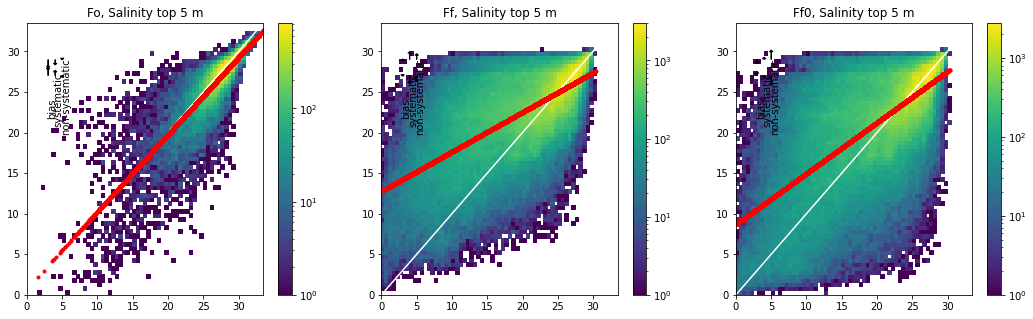

In [324]:
temp1 = read_pieces(pieces1)
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)

temp2 = read_pieces(pieces2)
temp2['SA'] = temp2['salinity (g/kg)']
temp2.drop(columns='Unnamed: 0', inplace=True)
temp2.drop_duplicates(inplace=True)

temp3 = read_pieces(pieces3)
temp3['SA'] = temp3['salinity (g/kg)']
temp3.drop(columns='Unnamed: 0', inplace=True)
temp3.drop_duplicates(inplace=True)

dowhich = ['Fo', 'Ff', 'Ff0'] 

Fo, Ff, Ff0 = triple_plots(dowhich, temp1, cleanup_ferry(temp2), cleanup_ferry(temp3))

alltogethero = pd.concat([d201812o, d201905o,  Cp2o,  Dagaino, 
                        DnoCilo,  DLowRo, Cp3o, Fo], axis=0)
alltogetherf = pd.concat([d201812f,  d201905f,  Cp2f,  Dagainf,
                         DnoCilf,  DLowRf, Cp3f, Ff, Cp3f0, Ff0], axis=0)
alltogethero.style.format(myformat).apply(highlight_max_min)

In [325]:
alltogetherf.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812f,414515,1.9,5.2,0.22,0.51,1.2e+01,3.8,3.5,0.46
H201905f,414513,1.8,5.1,0.21,0.5,1.2e+01,3.7,3.6,0.44
Cp2f,417883,1.9,5.2,0.22,0.51,1.2e+01,3.8,3.6,0.46
Dagainf,414515,1.8,5.2,0.22,0.51,1.2e+01,3.7,3.6,0.45
DnoCilf,414513,1.9,5.2,0.23,0.52,1.3e+01,3.9,3.5,0.47
DLowRf,414514,1.9,5.2,0.22,0.51,1.2e+01,3.8,3.6,0.46
Cp3f,412012,2.1,5.2,0.22,0.51,1.3e+01,3.9,3.5,0.47
Ff,414513,2.1,5.2,0.23,0.51,1.3e+01,3.9,3.5,0.48
Cp3f0,414518,0.92,5.0,0.18,0.37,8.5,2.5,4.3,0.14
Ff0,414515,0.97,5.0,0.18,0.37,8.7,2.6,4.3,0.16


In [361]:
pieces1 = ('/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ctd_20150101_20151231.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_psfts_20150101_20151231.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_pugts_20150101_20151231.csv',
           '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ctd_20160101_20161231.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_psfts_20160101_20161231.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_pugts_20160101_20161231.csv',
           '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ctd_20170101_20171231.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_psfts_20170101_20171231.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_pugts_20170101_20171231.csv',
          )
pieces2 = ('/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ferry_20150101_20150331.csv',
           '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ferry_20150401_20150630.csv',
           '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ferry_20150701_20150930.csv',
           '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ferry_20151001_20151231.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ferry_20160101_20161231.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ferry_20170101_20171231.csv',)
pieces3 = (
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1f0_ferry_20150101_20151231.csv',
    '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1f0_ferry_20160101_20161231.csv',
    '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1f0_ferry_20170101_20171231.csv',
         )

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812o,39364,-0.75,2.3,0.1,0.058,0.8,0.84,2.1,-0.35
H201905o,39364,-0.77,2.3,0.1,0.058,0.78,0.86,2.1,-0.35
Cp2o,39325,-0.77,2.3,0.1,0.052,0.64,0.84,2.1,-0.38
Dagaino,39304,-0.77,2.3,0.1,0.057,0.77,0.85,2.1,-0.35
DnoCilo,39364,-0.79,2.3,0.1,0.047,0.46,0.86,2.1,-0.37
DLowRo,39364,-0.79,2.3,0.1,0.046,0.44,0.86,2.2,-0.38
Cp3o,39364,-0.57,2.0,0.085,0.05,0.78,0.64,1.9,-0.29
Fo,39364,-0.58,2.0,0.084,0.05,0.76,0.65,1.9,-0.28
Gp1o,39337,-0.51,1.9,0.075,0.041,0.59,0.57,1.8,-0.26


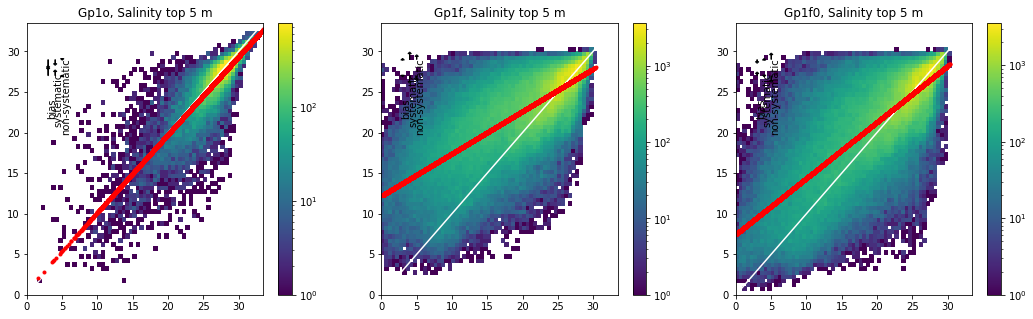

In [327]:
temp1 = read_pieces(pieces1)
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)

temp2 = read_pieces(pieces2)
temp2['SA'] = temp2['salinity (g/kg)']
temp2.drop(columns='Unnamed: 0', inplace=True)
temp2.drop_duplicates(inplace=True)

temp3 = read_pieces(pieces3)
temp3['SA'] = temp3['salinity (g/kg)']
temp3.drop(columns='Unnamed: 0', inplace=True)
temp3.drop_duplicates(inplace=True)

dowhich = ['Gp1o', 'Gp1f', 'Gp1f0'] 

Gp1o, Gp1f, Gp1f0 = triple_plots(dowhich, temp1[temp1.mod_vosaline != 0], cleanup_ferry(temp2), cleanup_ferry(temp3))

alltogethero = pd.concat([d201812o, d201905o,  Cp2o,  Dagaino, 
                        DnoCilo,  DLowRo, Cp3o, Fo, Gp1o], axis=0)
alltogetherf = pd.concat([d201812f,  d201905f,  Cp2f,  Dagainf,
                         DnoCilf,  DLowRf, Cp3f, Ff, Gp1f, Cp3f0, Ff0, Gp1f0], axis=0)
alltogethero.style.format(myformat).apply(highlight_max_min)

In [328]:
alltogetherf.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812f,414515,1.9,5.2,0.22,0.51,1.2e+01,3.8,3.5,0.46
H201905f,414513,1.8,5.1,0.21,0.5,1.2e+01,3.7,3.6,0.44
Cp2f,417883,1.9,5.2,0.22,0.51,1.2e+01,3.8,3.6,0.46
Dagainf,414515,1.8,5.2,0.22,0.51,1.2e+01,3.7,3.6,0.45
DnoCilf,414513,1.9,5.2,0.23,0.52,1.3e+01,3.9,3.5,0.47
DLowRf,414514,1.9,5.2,0.22,0.51,1.2e+01,3.8,3.6,0.46
Cp3f,412012,2.1,5.2,0.22,0.51,1.3e+01,3.9,3.5,0.47
Ff,414513,2.1,5.2,0.23,0.51,1.3e+01,3.9,3.5,0.48
Gp1f,413574,2.3,5.0,0.2,0.48,1.2e+01,3.8,3.2,0.49
Cp3f0,414518,0.92,5.0,0.18,0.37,8.5,2.5,4.3,0.14


In [359]:
pieces1 = ('/home/sallen/202007/202007G-p2/ObsModel_202007Gp2_ctd_20150101_20151231.csv',
          '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2_psfts_20150101_20151231.csv',
          '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2_pugts_20150101_20151231.csv',
        '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_ctd_20160101_20161231.csv',
           '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_psfts_20160101_20161231.csv',
           '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_pugts_20160101_20161231.csv',
           '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_ctd_20170101_20171231.csv',
           '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_psfts_20170101_20171231.csv',
           '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_pugts_20170101_20171231.csv'
         )
pieces2 = (
          '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2_ferry_20150101_20151231.csv',
   
         )
pieces3 = (
    '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_ferry_20150101_20151231.csv',
    '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_ferry_20160101_20161231.csv',
    '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_ferry_20170101_20171231.csv',
)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812o,39364,-0.75,2.3,0.1,0.058,0.8,0.84,2.1,-0.35
H201905o,39364,-0.77,2.3,0.1,0.058,0.78,0.86,2.1,-0.35
Cp2o,39325,-0.77,2.3,0.1,0.052,0.64,0.84,2.1,-0.38
Dagaino,39304,-0.77,2.3,0.1,0.057,0.77,0.85,2.1,-0.35
DnoCilo,39364,-0.79,2.3,0.1,0.047,0.46,0.86,2.1,-0.37
DLowRo,39364,-0.79,2.3,0.1,0.046,0.44,0.86,2.2,-0.38
Cp3o,39364,-0.57,2.0,0.085,0.05,0.78,0.64,1.9,-0.29
Fo,39364,-0.58,2.0,0.084,0.05,0.76,0.65,1.9,-0.28
Gp1o,39337,-0.51,1.9,0.075,0.041,0.59,0.57,1.8,-0.26
Gp2o,39337,-0.44,1.9,0.079,0.044,0.74,0.51,1.9,-0.27


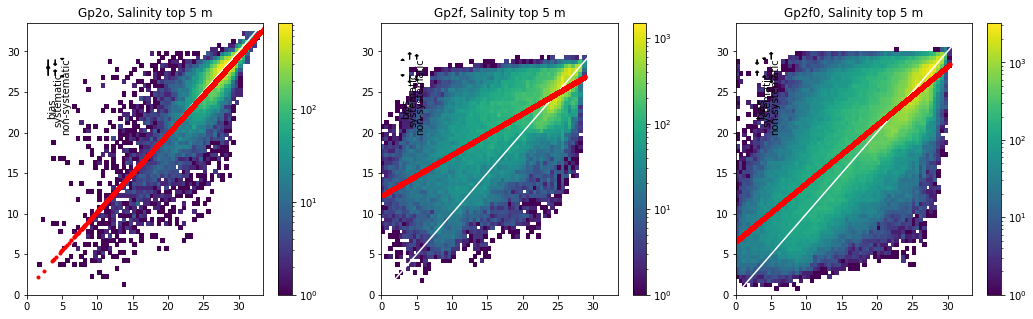

In [330]:
temp1 = read_pieces(pieces1)
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)

temp2 = read_pieces(pieces2)
temp2['SA'] = temp2['salinity (g/kg)']
temp2.drop(columns='Unnamed: 0', inplace=True)
temp2.drop_duplicates(inplace=True)

temp3 = read_pieces(pieces3)
temp3['SA'] = temp3['salinity (g/kg)']
temp3.drop(columns='Unnamed: 0', inplace=True)
temp3.drop_duplicates(inplace=True)

dowhich = ['Gp2o', 'Gp2f', 'Gp2f0'] 

Gp2o, Gp2f, Gp2f0 = triple_plots(dowhich, temp1[temp1.mod_vosaline != 0], cleanup_ferry(temp2), cleanup_ferry(temp3))

alltogethero = pd.concat([d201812o, d201905o,  Cp2o,  Dagaino, 
                        DnoCilo,  DLowRo, Cp3o, Fo, Gp1o, Gp2o], axis=0)
alltogetherf = pd.concat([d201812f,  d201905f,  Cp2f,  Dagainf,
                         DnoCilf,  DLowRf, Cp3f, Ff, Gp1f, Cp3f0, Ff0, Gp1f0, Gp2f0], axis=0)
alltogethero.style.format(myformat).apply(highlight_max_min)

In [331]:
alltogetherf.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812f,414515,1.9,5.2,0.22,0.51,1.2e+01,3.8,3.5,0.46
H201905f,414513,1.8,5.1,0.21,0.5,1.2e+01,3.7,3.6,0.44
Cp2f,417883,1.9,5.2,0.22,0.51,1.2e+01,3.8,3.6,0.46
Dagainf,414515,1.8,5.2,0.22,0.51,1.2e+01,3.7,3.6,0.45
DnoCilf,414513,1.9,5.2,0.23,0.52,1.3e+01,3.9,3.5,0.47
DLowRf,414514,1.9,5.2,0.22,0.51,1.2e+01,3.8,3.6,0.46
Cp3f,412012,2.1,5.2,0.22,0.51,1.3e+01,3.9,3.5,0.47
Ff,414513,2.1,5.2,0.23,0.51,1.3e+01,3.9,3.5,0.48
Gp1f,413574,2.3,5.0,0.2,0.48,1.2e+01,3.8,3.2,0.49
Cp3f0,414518,0.92,5.0,0.18,0.37,8.5,2.5,4.3,0.14


In [360]:
temp4 = read_pieces(pieces1+pieces3)
temp4['SA'] = temp4.SA.fillna(value=temp4['salinity (g/kg)'])
#temp4['SA'] = temp4['salinity (g/kg)']
temp4.drop(columns='Unnamed: 0', inplace=True)
temp4.drop_duplicates(inplace=True)

In [362]:
temp1 = read_pieces(pieces1+pieces3)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp4['SA'] = temp4['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
<ipython-input-425-aad5356746b5>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  colours = axs[1, 0].pcolormesh(sals, sals, (counts2 - counts1).transpose(), cmap='bwr', vmax=400, vmin=-400)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Gp1,453835,0.93,4.1,0.12,0.3,7.3,2.1,3.5,0.25
Gp2,453833,0.67,4.1,0.12,0.27,6.4,1.9,3.7,0.18


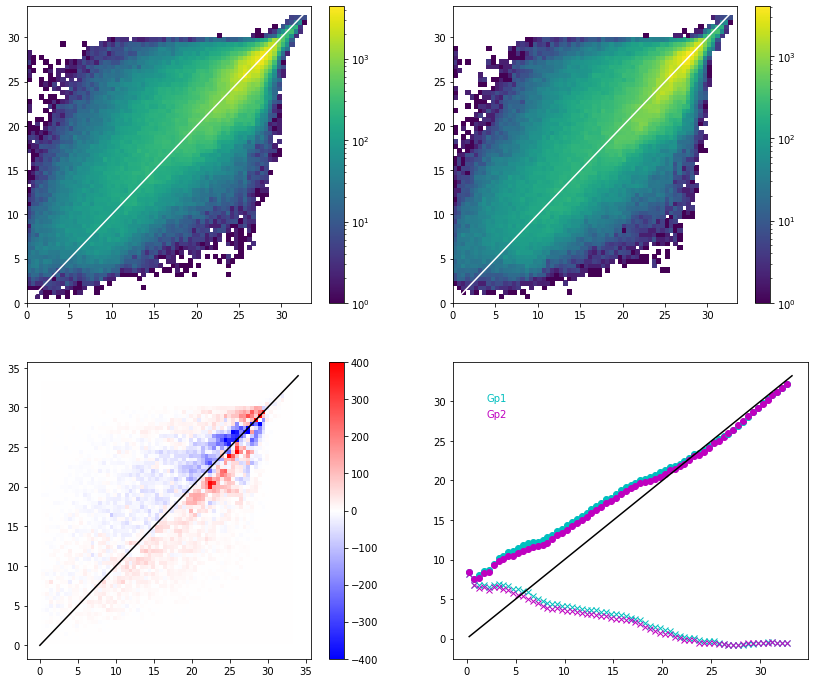

In [425]:
fig, axs = plt.subplots(2, 2, figsize=(14, 12))
Gp1, counts1 = plot_and_stats(fig, axs[0, 0], cleanup_ferry(temp1[temp1.mod_vosaline != 0]), 'Gp1',withpred=False, witharrows=False)
Gp2, counts2 = plot_and_stats(fig, axs[0, 1], cleanup_ferry(temp4[temp4.mod_vosaline != 0]), 'Gp2',withpred=False, witharrows=False)
sals = np.arange(0.25, 33.75, 0.5)
colours = axs[1, 0].pcolormesh(sals, sals, (counts2 - counts1).transpose(), cmap='bwr', vmax=400, vmin=-400)
axs[1, 0].plot([0, 34], [0, 34], 'k')
fig.colorbar(colours, ax= axs[1, 0])
for ii in range(67):
    if counts1[ii, :].sum() > 0:
        axs[1, 1].plot(sals[ii], np.average(sals, weights=counts1[ii, :]), 'co')
        axs[1, 1].plot(sals[ii], np.average(sals, weights=counts1[ii, :]) - sals[ii], 'cx')
    if counts2[ii, :].sum() > 0:
        axs[1, 1].plot(sals[ii], np.average(sals, weights=counts2[ii, :]), 'mo')
        axs[1, 1].plot(sals[ii], np.average(sals, weights=counts2[ii, :]) - sals[ii], 'mx')
axs[1, 1].plot(sals, sals, 'k-')
axs[1, 1].text(2, 30, 'Gp1', color='c')
axs[1, 1].text(2, 28, 'Gp2', color='m')
alltogether = pd.concat([Gp1, Gp2], axis=0)
alltogether.style.format(myformat).apply(highlight_max_min)


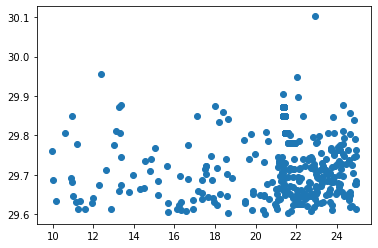

In [433]:
maxi = 29.6
plt.plot(temp4.SA[(temp4.mod_vosaline > maxi) & (temp4.SA < 25)], 
         temp4.mod_vosaline[(temp4.mod_vosaline > maxi) & (temp4.SA < 25)], 'o')

(48.9, 49.3)

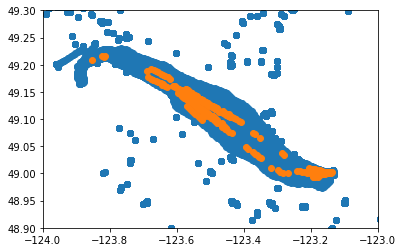

In [450]:
plt.plot(temp4.Lon, temp4.Lat, 'o')
plt.plot(temp4.Lon[(temp4.mod_vosaline > maxi) & (temp4.SA < 25)], 
         temp4.Lat[(temp4.mod_vosaline > maxi) & (temp4.SA < 25)], 'o')
pd.set_option('display.max_columns', None)
whatIwant = temp4[(temp4.mod_vosaline > maxi) & (temp4.SA < 25)][-400:]
plt.xlim(-124, -123)
plt.ylim(48.9, 49.3)

In [452]:
whatIwant['dtUTC'] = pd.to_datetime(whatIwant['dtUTC'])


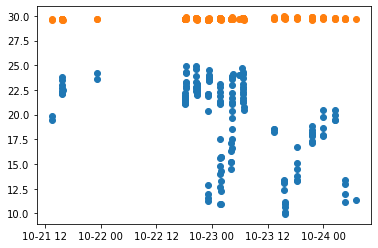

In [461]:
last_incident = -159
plt.plot(whatIwant[last_incident:].dtUTC, whatIwant.SA[last_incident:], 'o')
plt.plot(whatIwant[last_incident:].dtUTC, whatIwant.mod_vosaline[last_incident:], 'o')

In [486]:
flow = pd.read_csv('/home/sallen/MEOPAR/tools/I_ForcingFiles/Rivers/river_flows/Nicomekl_203_flow', header=None, sep=' ', dtype={0: 'int64',
                                                                                                                         1: 'int64',
                                                                                                                         2: 'int64'},
            
           )
#
#df = pd.read_csv(file, header=None, index_col='datetime', 
#                 parse_dates={'datetime': [1,2,3,4]}, 
#                 date_parser=lambda x: pd.datetime.strptime(x, '%Y %m %d %H'))
flow.rename(columns={0: "Year", 1: "Month", 2: "Day", 3: 'Flow'}, inplace=True)
#pd.to_datetime(df[['year', 'month', 'day']])
flow['datetime'] = pd.to_datetime(flow[['Year', 'Month', 'Day']])
flow.set_index('datetime', inplace=True)
flow

,Year,Month,Day,Flow
datetime,,,,
1985-01-29,1985,1,29,0.806000
1985-01-30,1985,1,30,0.705000
1985-01-31,1985,1,31,0.648000
1985-02-01,1985,2,1,0.684000
1985-02-02,1985,2,2,0.662000
...,...,...,...,...
2020-12-30,2020,12,30,12.370490
2020-12-31,2020,12,31,18.568590
2021-01-01,2021,1,1,9.472535


In [491]:
roberts = pd.read_csv('/home/sallen/MEOPAR/tools/I_ForcingFiles/Rivers/river_flows/Roberts_Roberts_flow', header=None, sep=' ', dtype={0: 'int64',
                                                                                                                         1: 'int64',
                                                                                                                         2: 'int64'},
            
           )
#
#df = pd.read_csv(file, header=None, index_col='datetime', 
#                 parse_dates={'datetime': [1,2,3,4]}, 
#                 date_parser=lambda x: pd.datetime.strptime(x, '%Y %m %d %H'))
roberts.rename(columns={0: "Year", 1: "Month", 2: "Day", 3: 'Flow'}, inplace=True)
#pd.to_datetime(df[['year', 'month', 'day']])
roberts['datetime'] = pd.to_datetime(roberts[['Year', 'Month', 'Day']])
roberts.set_index('datetime', inplace=True)
roberts

,Year,Month,Day,Flow
datetime,,,,
1959-04-28,1959,4,28,1.250
1959-04-29,1959,4,29,5.660
1959-04-30,1959,4,30,3.680
1959-05-01,1959,5,1,5.890
1959-05-02,1959,5,2,1.250
...,...,...,...,...
2019-12-27,2019,12,27,0.625
2019-12-28,2019,12,28,0.571
2019-12-29,2019,12,29,0.843


(17410.0, 17531.0)

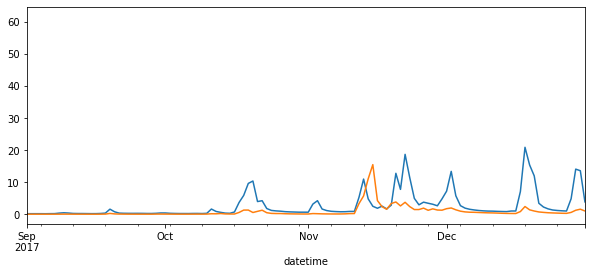

In [497]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
flow.Flow.plot()
roberts.Flow.plot()
plt.xlim(dt.datetime(2017, 9, 1), dt.datetime(2017, 12, 31))

In [502]:
# Huge Oct 12, 2017 storm (https://dailyhive.com/vancouver/vancouver-flooding-rainfall-october-12-2017) not picked up in river flows!

In [593]:
atmos1 = xr.open_dataset('/results/forcing/atmospheric/GEM2.5/operational/ops_y2017m10d11.nc')
atmos2 = xr.open_dataset('/results/forcing/atmospheric/GEM2.5/operational/ops_y2017m10d12.nc')
atmos3 = xr.open_dataset('/results/forcing/atmospheric/GEM2.5/operational/ops_y2017m10d13.nc')
atmos4 = xr.open_dataset('/results/forcing/atmospheric/GEM2.5/operational/ops_y2017m10d14.nc')

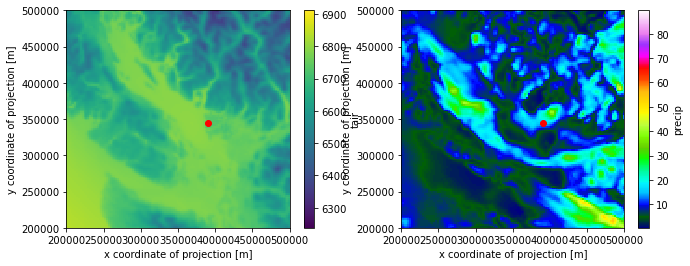

In [594]:
fig, axs = plt.subplots(1, 2, figsize=(11, 4))
atmos.tair.sum(axis=0).plot(ax=axs[0])
((atmos1.precip.mean(axis=0)+
  atmos2.precip.mean(axis=0)+
  atmos3.precip.mean(axis=0)+
  atmos4.precip.mean(axis=0))/4.*(4*86400)).plot(ax=axs[1], cmap='gist_ncar')
for ax in axs:
    ax.set_xlim(200000, 500000)
    ax.set_ylim(200000, 500000)
    ax.plot(390000, 345000, 'ro')

In [597]:
atmos1 = xr.open_dataset('/results/forcing/atmospheric/GEM2.5/operational/ops_y2017m10d18.nc')
atmos2 = xr.open_dataset('/results/forcing/atmospheric/GEM2.5/operational/ops_y2017m10d19.nc')
atmos3 = xr.open_dataset('/results/forcing/atmospheric/GEM2.5/operational/ops_y2017m10d20.nc')
atmos4 = xr.open_dataset('/results/forcing/atmospheric/GEM2.5/operational/ops_y2017m10d21.nc')

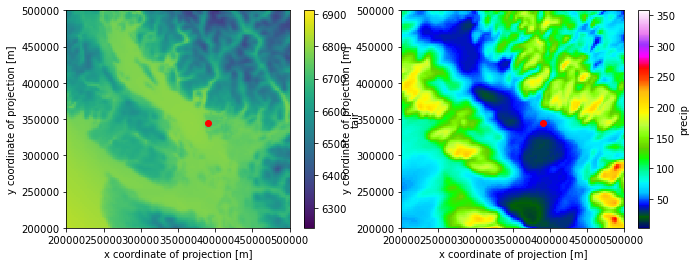

In [598]:
fig, axs = plt.subplots(1, 2, figsize=(11, 4))
atmos.tair.sum(axis=0).plot(ax=axs[0])
((atmos1.precip.mean(axis=0)+
  atmos2.precip.mean(axis=0)+
  atmos3.precip.mean(axis=0)+
  atmos4.precip.mean(axis=0))/4*4*86400).plot(ax=axs[1], cmap='gist_ncar')
for ax in axs:
    ax.set_xlim(200000, 500000)
    ax.set_ylim(200000, 500000)
    ax.plot(390000, 345000, 'ro')

In [ ]:
# First storm is a miss.  Second storm is good with 50 mm of rain at YVR
                                                         this column
09 	15.2 	5.5 	10.4 	7.6 	0.0 	0.0 	0.0 	0.0 	  	  	<31
10 	12.3 	6.5 	9.4 	8.6 	0.0 	3.1 	0.0 	3.1 	  	28 	39
11 	13.4 	6.6 	10.0 	8.0 	0.0 	2.2 	0.0 	2.2 	  	  	<31
12 	9.6 	6.1 	7.9 	10.1 	0.0 	31.4 	0.0 	31.4 	  	6 	35
13 	11.4 	4.6 	8.0 	10.0 	0.0 	1.0 	0.0 	1.0 	  	29 	41
14 	10.4 	5.2 	7.8 	10.2 	0.0 	0.2 	0.0 	0.2 	  	4 	37
15 	13.6 	8.7 	11.2 	6.8 	0.0 	0.0 	0.0 	0.0 	  	  	<31
16 	11.9 	10.2 	11.1 	6.9 	0.0 	8.2 	0.0 	8.2 	  	10 	33
17 	14.1 	8.4 	11.3 	6.7 	0.0 	2.2 	0.0 	2.2 	  	27 	65
18 	12.5 	7.7 	10.1 	7.9 	0.0 	33.4 	0.0 	33.4 	  	17 	50
19 	12.2 	9.1 	10.7 	7.3 	0.0 	10.0 	0.0 	10.0 	  	14 	39
20 	12.6 	6.2 	9.4 	8.6 	0.0 	9.4 	0.0 	9.4 	  	19 	39
21 	9.6 	7.0 	8.3 	9.7 	0.0 	8.2 	0.0 	8.2 	  	6 	44 

In [265]:
def highlight_max_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = abs(s) == abs(s).max()
    is_min = abs(s) == abs(s).min()
    color = []
    for v, v2 in zip(is_max, is_min):
        if v:
            color.append('red')
        elif v2:
            color.append('darkgreen')
        else:
            color.append('black')
    return ['color: %s' % color[i] for i in range(len(is_max))]

In [266]:
## Now look at Distribution

In [343]:
pieces = (#'/home/sallen/202007/202007G-p2/ObsModel_202007Gp2_ctd_20150101_20151231.csv',
          #'/home/sallen/202007/202007G-p2/ObsModel_202007Gp2_psfts_20150101_20151231.csv',
          #'/home/sallen/202007/202007G-p2/ObsModel_202007Gp2_pugts_20150101_20151231.csv',
          '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2_ferry_20150101_20151231.csv',
           '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2_ferry_20150101_20151231.csv'
         )

In [344]:
temp1 = read_pieces(pieces)
#temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)

In [341]:
pieces = (#'/home/sallen/202007/202007F/ObsModel_202007F_ctd_20150101_20151231.csv',
          #'/home/sallen/202007/202007F/ObsModel_202007F_psfts_20150101_20151231.csv',
         #'/home/sallen/202007/202007F/ObsModel_202007F_pugts_20150101_20151231.csv',
        # '/home/sallen/202007/202007F/ObsModel_202007F_ctd_20160101_20161231.csv',
        #  '/home/sallen/202007/202007F/ObsModel_202007F_psfts_20160101_20161231.csv',
        # '/home/sallen/202007/202007F/ObsModel_202007F_pugts_20160101_20161231.csv',
        # '/home/sallen/202007/202007F/ObsModel_202007F_ctd_20170101_20171231.csv',
        #  '/home/sallen/202007/202007F/ObsModel_202007F_psfts_20170101_20171231.csv',
        # '/home/sallen/202007/202007F/ObsModel_202007F_pugts_20170101_20171231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_ferry_20150101_20151231.csv',
    '/home/sallen/202007/202007F/ObsModel_202007F_ferry_20160101_20161231.csv',
    '/home/sallen/202007/202007F/ObsModel_202007F_ferry_20170101_20171231.csv',
        # '/home/sallen/202007/202007F/ObsModel_202007F_ferry_20160101_20161231.csv',
        # '/home/sallen/202007/202007F/ObsModel_202007F_ferry_20170101_20171231.csv'
         )

In [342]:
temp2 = read_pieces(pieces)
#temp2['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
temp2['SA'] = temp2['salinity (g/kg)']
temp2.drop(columns='Unnamed: 0', inplace=True)
temp2.drop_duplicates(inplace=True)

In [345]:
pieces = (
         '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ferry_20150101_20151231.csv',
    '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ferry_20160101_20161231.csv',
    '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ferry_20170101_20171231.csv',
         )

In [346]:
temp3 = read_pieces(pieces)
#temp2['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
temp3['SA'] = temp3['salinity (g/kg)']
temp3.drop(columns='Unnamed: 0', inplace=True)
temp3.drop_duplicates(inplace=True)

In [347]:
pieces = (
         '/home/sallen/202007/202007F/ObsModel_202007F0f_ferry_20150101_20151231.csv',
    '/home/sallen/202007/202007F/ObsModel_202007F0f_ferry_20160101_20161231.csv',
    '/home/sallen/202007/202007F/ObsModel_202007F0f_ferry_20170101_20171231.csv',
         )

In [348]:
temp4 = read_pieces(pieces)
#temp2['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
temp4['SA'] = temp4['salinity (g/kg)']
temp4.drop(columns='Unnamed: 0', inplace=True)
temp4.drop_duplicates(inplace=True)

In [349]:
pieces = (
         '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1f0_ferry_20150101_20151231.csv',
    '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1f0_ferry_20160101_20161231.csv',
     '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1f0_ferry_20170101_20171231.csv',
         )

In [350]:
tempGp1f = read_pieces(pieces)
#temp2['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
tempGp1f['SA'] = tempGp1f['salinity (g/kg)']
tempGp1f.drop(columns='Unnamed: 0', inplace=True)
tempGp1f.drop_duplicates(inplace=True)

In [351]:
pieces = (
         '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_ferry_20150101_20151231.csv',
    '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_ferry_20160101_20161231.csv',
    '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_ferry_20170101_20171231.csv',
         )

In [352]:
tempGp2f = read_pieces(pieces)
#temp2['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
tempGp2f['SA'] = tempGp2f['salinity (g/kg)']
tempGp2f.drop(columns='Unnamed: 0', inplace=True)
tempGp2f.drop_duplicates(inplace=True)

In [279]:
## Some Quick Looks at Distribution

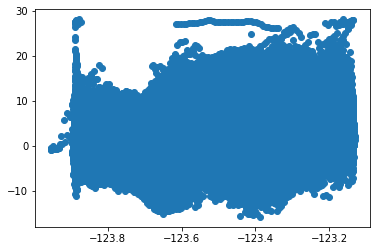

In [353]:
plt.plot(temp3.Lon, temp3.mod_vosaline - temp3.SA, 'o')

In [281]:
## Remove some bad data
#cleaned = temp3[(temp3.Lon > -123.8) | (temp3.SA > 14)]
more_clean = temp3[((temp3.SA > 0.2) | (temp3.mod_vosaline - temp3.SA < 20)) & ((temp3.Lon > -123.8) | (temp3.SA > 14))]

In [282]:
def cleanup_ferry(temp3):
    return temp3[((temp3.SA > 0.2) | (temp3.mod_vosaline - temp3.SA < 20)) & ((temp3.Lon > -123.8) | (temp3.SA > 14))]

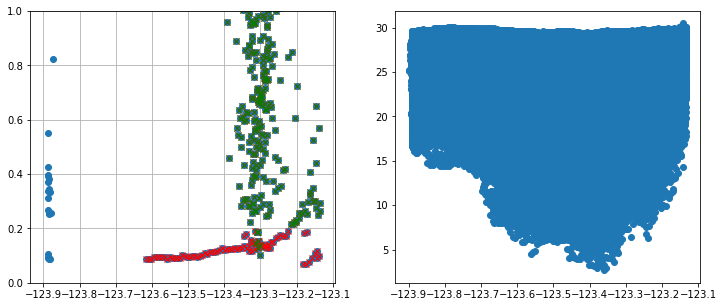

In [283]:
fig, axs = plt.subplots(1, 2, figsize= (12, 5))
axs[0].plot(temp3.Lon, temp3.SA, 'o');
axs[0].plot(cleaned.Lon, cleaned.SA, 'rx');
axs[0].plot(more_clean.Lon, more_clean.SA, 'gx')
axs[1].plot(temp3.Lon, temp3.mod_vosaline, 'o');
axs[0].set_ylim(0, 1);
axs[0].grid();

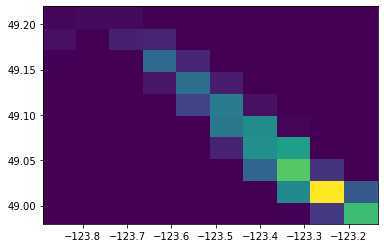

In [354]:
plt.hist2d(temp1.Lon[temp3.mod_vosaline-temp3.SA > 5], temp1.Lat[temp3.mod_vosaline-temp3.SA > 5]);

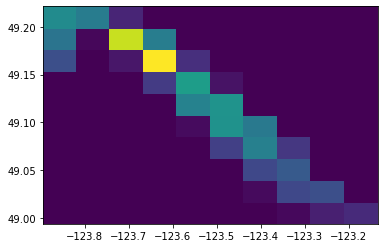

In [355]:
plt.hist2d(temp1.Lon[temp3.mod_vosaline-temp3.SA < -5], temp1.Lat[temp3.mod_vosaline-temp3.SA < -5]);

0.9873737434370927
0.007705370135159151
415312


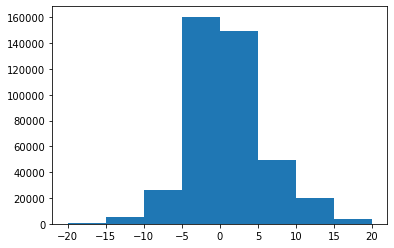

In [356]:
plt.hist(temp4.mod_vosaline - temp4.SA, bins=[-20, -15, -10, -5, 0, 5, 10, 15, 20])
print ((temp4.mod_vosaline - temp4.SA).mean())
print ((temp4.mod_vosaline - temp4.SA).std()/np.sqrt((temp4.mod_vosaline - temp4.SA).count()))
print ((temp4.mod_vosaline - temp4.SA).count())

In [287]:
## And now bin across the Strait

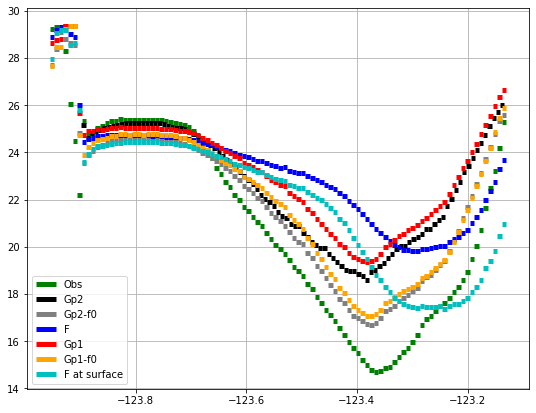

In [357]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7))
bin_means, bin_edges, binnumber = stats.binned_statistic(temp4.Lon, temp4.SA, 'mean', bins=100)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=5,
               label='Obs');
bin_means, bin_edges, binnumber = stats.binned_statistic(temp1.Lon, temp1.mod_vosaline, 'mean', bins=100)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='k', lw=5,
               label='Gp2');
bin_means, bin_edges, binnumber = stats.binned_statistic(tempGp2f.Lon, tempGp2f.mod_vosaline, 'mean', bins=100)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='gray', lw=5,
               label='Gp2-f0');
bin_means, bin_edges, binnumber = stats.binned_statistic(temp2.Lon, temp2.mod_vosaline, 'mean', bins=100)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='b', lw=5,
               label='F');
bin_means, bin_edges, binnumber = stats.binned_statistic(temp3.Lon, temp3.mod_vosaline, 'mean', bins=100)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5,
               label='Gp1');
bin_means, bin_edges, binnumber = stats.binned_statistic(tempGp1f.Lon, tempGp1f.mod_vosaline, 'mean', bins=100)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='orange', lw=5,
               label='Gp1-f0');
bin_means, bin_edges, binnumber = stats.binned_statistic(temp4.Lon, temp4.mod_vosaline, 'mean', bins=100)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='c', lw=5,
               label='F at surface');
plt.grid();
plt.legend(loc='lower left');

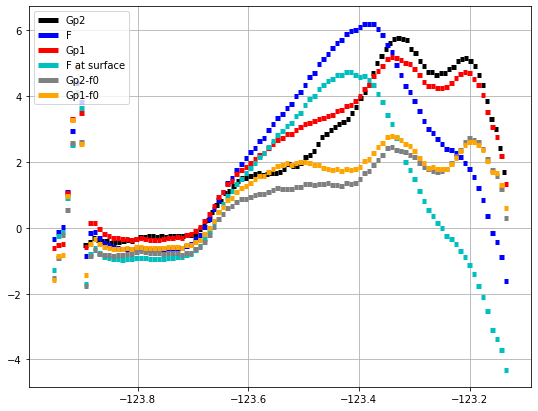

In [358]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7))
bin_means, bin_edges, binnumber = stats.binned_statistic(temp1.Lon, temp1.mod_vosaline - temp1.SA, 'mean', bins=100)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='k', lw=5,
               label='Gp2');
bin_means, bin_edges, binnumber = stats.binned_statistic(temp2.Lon, temp2.mod_vosaline - temp2.SA, 'mean', bins=100)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='b', lw=5,
               label='F');
bin_means, bin_edges, binnumber = stats.binned_statistic(temp3.Lon, temp3.mod_vosaline - temp3.SA, 'mean', bins=100)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5,
               label='Gp1');
bin_means, bin_edges, binnumber = stats.binned_statistic(temp4.Lon, temp4.mod_vosaline - temp4.SA, 'mean', bins=100)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='c', lw=5,
               label='F at surface');
bin_means, bin_edges, binnumber = stats.binned_statistic(tempGp2f.Lon, tempGp2f.mod_vosaline - tempGp2f.SA, 'mean', bins=100)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='gray', lw=5,
               label='Gp2-f0');
bin_means, bin_edges, binnumber = stats.binned_statistic(tempGp1f.Lon, tempGp1f.mod_vosaline - tempGp1f.SA, 'mean', bins=100)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='orange', lw=5,
               label='Gp1-f0');
plt.legend(loc='upper left');
plt.grid();